In [1]:
import numpy as np
import sys
sys.path.append("../code/")
from structure import *
from algo import *
from basic import *
from analysis import *
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from autograd.numpy import linalg as LA
import pickle
import itertools
from itertools import product
import calendar
from sklearn.metrics import mean_squared_error
%load_ext autoreload
%autoreload 2
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import matplotlib
matplotlib.rcParams['ps.useafm']=True
matplotlib.rcParams['pdf.use14corefonts']=True
matplotlib.rcParams['text.usetex']=True

In [5]:
year = 2015
dataset = 'artificial_old'
order = APP_NAME_OBSERVED

In [10]:
# load the selected pairs with the best parameter
dataset = 'artificial_old'
result = {}
method = 'active'
uncertainty = 'prev_future_weighted'
param = np.load("../data/best-param-{}-active.npy".format(year)).item()
k, latent_dimension, lambda1, lambda2, lambda3, kernel, sigma = param.split("-")

result['active'] = {}
for k in[1, 2, 3, 5, 8, 10, 15, 20]:
    print(k)
    result['active'][k] = get_active_results(year=year, dataset=dataset, method=method, kernel=kernel, sigma=int(sigma),
                                          lambda1=int(lambda1), lambda2=int(lambda2), lambda3=int(lambda3), k=k,
                                          latent_dimension=int(latent_dimension), uncertainty=uncertainty)    

dataset = 'artificial'
for method in ['random', 'qbc']:
    print(method)
    result[method] = {}
    param = np.load("../data/best-param-{}-{}.npy".format(year, method)).item()
    k, latent_dimension, lambda1, lambda2, lambda3 = param.split("-")
    for k in [1, 2, 3, 5, 8, 10, 15, 20]:
        result[method][k] = get_active_results(year=year, dataset=dataset, method=method, lambda1=int(lambda1),
                                              lambda2=int(lambda2), lambda3=int(lambda3), k=k)

1
2
3
5
8
10
15
20
random
qbc


In [15]:
param

'5-4-0.01-1.0-0.01-1.0-1.0-0.1-4'

In [17]:
# get the result of vbi
param = np.load("../data/best-param-2015-vb-new.npy").item()
k, latent_dimension, a_gamma, b_gamma, a_beta, b_beta, a_alpha, b_alpha, random_seed = param.split("-")


r = {}
for k in [1, 2, 3, 5, 8, 10, 15, 20]:

    pre_dir = "../data/result/vb_var/{}/artificial".format(year)

    param_name = "{}-{}-{}-{}-{}-{}-{}-{}".format(k, latent_dimension, a_gamma,
                                                  b_gamma, a_beta, b_beta, a_alpha,
                                                  b_alpha)

    full_path = "{}/pred-{}".format(pre_dir, param_name)
#     print(full_path)
    r[k] = np.load(full_path)

mean_vb = {}
tensor, hid = get_tensor(year, dataset)
for p in r.keys():
    for random_seed in range(5):
        mean_vb[p] = {}
        for t in range(12):
            mean_vb[p][t] = {}
            for idx, app in enumerate(APPLIANCE_ORDER_OBSERVED[1:]):
                idx += 1
                mean_vb[p][t][idx] = np.sqrt(mean_squared_error(r[p][random_seed][t][:, idx, t], tensor[:, idx, t]))

mean_error_vb = {}
for p in mean_vb.keys():
    mean_error_vb[p] = {}
    for t in range(12):
        mean_error_vb[p][t] = pd.Series(mean_vb[p][t]).mean()

In [18]:
pd.DataFrame(mean_error_vb).mean()

1     127.260019
2     115.129308
3     108.764244
5      96.334394
8      84.328925
10     79.808696
15     81.936733
20     78.203227
dtype: float64

In [19]:
error = {}
for e_type in ['overall', 'app']:
    error[e_type] = {}
    for t_type in ['accu', 'month']:
        error[e_type][t_type] = {}
        for param in result.keys():
            error[e_type][t_type][param] = {}
            for k in [1, 2, 3, 5, 8, 10, 15, 20]:
                error[e_type][t_type][param][k] = {}
                for idx, appliance in enumerate(order[1:]):
                    error[e_type][t_type][param][k][appliance] = {}
                    for t in range(12):
                        error[e_type][t_type][param][k][appliance][t] = {}
                        for random_seed in range(5):
                            error[e_type][t_type][param][k][appliance][t][random_seed] = {}

In [20]:
tensor, homeidx = get_tensor(year, dataset)
mask_tensor = ~np.isnan(tensor)

In [21]:
for param in result.keys():
    for k in [1, 2, 3, 5, 8, 10, 15, 20]:
        for t in range(12):
            # random method
            for idx, appliance in enumerate(order[1:]):
                idx += 1
                for random_seed in range(10):
                    # for active method
                    predApp = result[param][k]['prediction'][random_seed][t][:, idx, :] # tensor
                    predApp[predApp<0] = 0

                    # accumulated appliance error
                    appAccuPred = predApp[:, :(t+1)]
    #                 print(appliance, appAccuPred.min())
                    error['app']['accu'][param][k][appliance][t][random_seed] = np.sqrt(mean_squared_error(appAccuPred[mask_tensor[:, idx, :(t+1)]], 
                                                                                                   tensor[:, idx, :(t+1)][mask_tensor[:, idx, :(t+1)]]))
                    # appliance error in current month
                    appMonthPred = predApp[:, t]
                    error['app']['month'][param][k][appliance][t][random_seed] = np.sqrt(mean_squared_error(appMonthPred[mask_tensor[:, idx, t]], 
                                                                                                    tensor[:, idx, t][mask_tensor[:, idx, t]]))



In [22]:
mean_error = {}
for param in result.keys():
    mean_error[param] = {}
    for k in [1, 2, 3, 5, 8, 10, 15, 20]:
        mean_error[param][k] = {}
        for appliance in order[1:]:
            mean_error[param][k][appliance] = pd.DataFrame(error['app']['month'][param][k][appliance]).mean(axis=0)

In [23]:
err = {}
for param in result.keys():
    err[param] = {}
    for k in [1, 2, 3, 5, 8, 10, 15, 20]:
        err[param][k] = pd.DataFrame(mean_error[param][k]).mean().mean()

In [24]:
err['var'] = pd.DataFrame(mean_error_vb).mean()

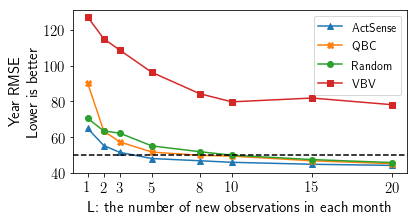

In [36]:
# from plot_functions import format_axes, latexify

# latexify(columns=1)

name_dict = {'qbc':'QBC', 'active':'ActSense', 'random':'Random', 'var':'VBV'}
df = pd.DataFrame(err)
df = df.rename(columns=name_dict)

ax = df.plot(style=['^-', 'X-', 'o-', 's-'], figsize=(6, 3))
ax.tick_params(labelsize=15)
ax.set_xticks([1, 2, 3, 5, 8, 10, 15, 20])
ax.set_xlabel("L: the number of new observations in each month", fontsize=15)
ax.set_ylabel("Year RMSE \nLower is better", fontsize=15)
ax.legend(fontsize=12)
# fig = ax.get_figure()
# fig.figsize(12, 12)
ax.annotate('50', xy=(50, 50), xytext=(0, 0.5), arrowprops=dict(facecolor='black', shrink=0.003, width=2), horizontalalignment='left', verticalalignment='bottom')

plt.axhline(y=50, linestyle='--', color='k')

# format_axes(ax)
plt.savefig("../figure/VaryingK.pdf", bbox_inches="tight")

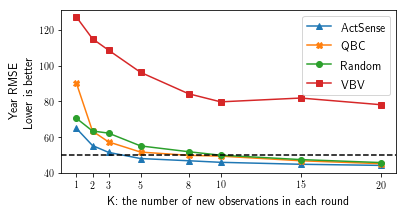

In [30]:
# from plot_functions import format_axes, latexify

# latexify(columns=1)

name_dict = {'qbc':'QBC', 'active':'ActSense', 'random':'Random', 'var':'VBV'}
df = pd.DataFrame(err)
df = df.rename(columns=name_dict)
ax = df.plot(style=['^-', 'X-', 'o-', 's-'], figsize=(6, 3))
ax.set_xticks([1, 2, 3, 5, 8, 10, 15, 20])
ax.set_xlabel("K: the number of new observations in each round", fontsize=12)
ax.set_ylabel("Year RMSE \nLower is better", fontsize=12)
ax.legend(fontsize=12)
# fig = ax.get_figure()
# fig.figsize(12, 12)
ax.annotate('50', xy=(50, 50), xytext=(0, 0.5), arrowprops=dict(facecolor='black', shrink=0.003, width=2), horizontalalignment='left', verticalalignment='bottom')

plt.axhline(y=50, linestyle='--', color='k')

# format_axes(ax)
plt.savefig("../figure/VaryingK.pdf", bbox_inches="tight")